# Visualizing the latent space for Scala 2020 data

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks_tf2

import time
import pickle
import warnings

dtype = tf.float32

# Loading data

In [5]:
scala = pickle.load(open('data/scala_2020/scala2020.pickle', 'rb'))
X=scala['X']
Y=scala['Y']
gene_names=scala['gene_names']
cell_types=scala['celltypes']
cell_id_to_cell_type=scala['map']
ephys_names=scala['ephys_features']
colors=scala['colors']

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [6]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(Y)

In [7]:
clusters = kmeans.labels_

In [8]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

# Keras initialisations

In [9]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(input_tensor=tf.square(residual)) / tf.reduce_sum(input_tensor=tf.square(y_truth))

In [4]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(input_tensor=tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(input_tensor=tf.norm(tensor=x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

# Running models and comparative analysis

First we train the lasso 1e-1 freeze (4 last layers) unfreeze model for the entire dataset.

In [11]:
importlib.reload(bottleneck_networks_tf2)

<module 'bottleneck_networks_tf2' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/sBNN/bottleneck_networks_tf2.py'>

In [12]:
from bottleneck_networks_tf2 import ClassificationPreTrain

In [13]:
cvfold_id=1111 # Random integer number given by you to save files
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
nodes_list=[512,128,2,128,512]

t = time.time()
np.random.seed(seed)
n = X.shape[0]
clusters_ = np.copy(clusters)

CE_loss = np.zeros((l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))


pre_train_size = 0.6
train_cnt = round(X.shape[0]*pre_train_size)
x_train_pre_tr_ = X[:train_cnt, :]
x_test_pre_tr_ = X[train_cnt:, :]
clusters_train_pre_tr_ = clusters_[:train_cnt]
clusters_test_pre_tr_ = clusters_[train_cnt:]

for i, l2 in enumerate(l2_params):
    #print('Ridge penalty: ', l2)
    for j, l1 in enumerate(l1_params):
        #print('Lasso penalty: ', l1)


        input_dim = x_train_pre_tr_.shape[1]
        output_dim = to_categorical(clusters_train_pre_tr_).shape[1]
        BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                   output_dim=output_dim, nodes_list=nodes_list)
        CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                           cluster_train=clusters_train_pre_tr_, \
                                                                           x_test=x_test_pre_tr_, \
                                                                           cluster_test=clusters_test_pre_tr_, \
                                                                           epochs=epochs, bs=bs, patience=patience, \
                                                                           cvfold_id=cvfold_id, l1_id=j, l2_id=i, \
                                                                           verbose=0, \
                                                                           output_name='scala_2020_tf2')
        CE_loss[j, i] = CE_test
        CE_loss_tr[j, i] = CE_train
        pre_tr_hist[j, i] = test_hist
        pre_tr_hist_tr[j, i] = train_hist
        #print('Test CE loss (pre-training): ', CE_loss[j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[INFO] training network...
[INFO] training network...
[INFO] training network...
Time: 0.0h  0m 50s


In [14]:
from bottleneck_networks_tf2 import FreezeUnfreeze

In [15]:
cvfold_id=1111 # Random integer number given by you to save files (We used 1000 to construct the one for the paper)

l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True
nodes_list=[512,128,2,128,512]

r2_freeze_unfreeze_hist_tr=np.zeros((l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr_AE=np.zeros((l1_params.shape[0], l2_params.shape[0], 2*epochs)) 

t = time.time()
np.random.seed(seed)
n = X.shape[0]

    
input_dim = X.shape[1]
output_dim = Y.shape[1]

for i, l2 in enumerate(l2_params):
    print('Ridge penalty: ', l2)
    for j, l1 in enumerate(l1_params):
        print('Lasso penalty: ', l1)

        pre_trained_weights_h5 = 'KerasSavedModels/scala_2020_tf2/Classification_last_weights_{}_{}_{}.h5'.format\
                                                                                               (cvfold_id, j, i)
        input_dim = X.shape[1]
        output_dim = Y.shape[1]
        BN_PreTrFreezeUnfreeze=FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                   unfreeze = unfreeze, \
                                                   pre_trained_weights=pre_trained_weights, \
                                                   pre_trained_weights_h5=pre_trained_weights_h5, \
                                                   nodes_list=nodes_list)
        train_hist, AE_hist=BN_PreTrFreezeUnfreeze.train_full_dataset(x_train=X, y_train=Y, \
                                                                epochs=epochs, bs=bs, patience=patience, \
                                                                cvfold_id=cvfold_id, l1_id=j, l2_id=i, \
                                                                prune=prune, geneNames=gene_names, \
                                                                verbose=0, add_autoencoder=True, \
                                                                output_name='scala_2020_tf2')
        r2_freeze_unfreeze_hist_tr[j, i]=train_hist
        r2_freeze_unfreeze_hist_tr_AE[j, i]=AE_hist
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Ridge penalty:  1e-10
Lasso penalty:  0.0001
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Ccl9' 'Thoc1' 'Ptk2b' 'Grm1' 'AW551984' 'Prkacb' 'Tiam2' 'Zfp551' 'Lcp1'
 'Idh3b' 'Prox1' 'Sema5a' 'Vip' 'Mdh1' 'Pvalb' 'Zfp719' '5330413P13Rik'
 '9530068E07Rik' 'Ighm' 'Grip1' 'Rit2' 'Gpc3' 'Egfr' 'Cct8' 'Sash3']
[INFO] training pr

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[INFO] training autoencoder network
Lasso penalty:  0.01
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Bcl2l11' 'Slc6a1' 'Grik1' 'Ptgs2' 'Pamr1' 'Nrp1' 'Tiam2' 'Hpse'
 'Sparcl1' 'Rph3a' 'Rasgrp1' 'Thsd7a' 'Eef1a1' 'Elmo1' 'Atp1a3' 'Dlx6os1'
 'Arpp19' 'Gm49948' 'Tnnt1' 'Cplx3' 'Prox1' 'Egfr' 'Gad1' 'Vip' 'Pvalb']
[INFO] training pruning network...
[INFO] training autoencoder network
Lasso penalty:  0.1
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Rab3b' 'Elmo1' 'Col24a1' 'Mybpc1' 'Parm1' 'Cacna1e' 'Cplx3' 'Reln'
 'Cbln2' 'Calb1' 'Npy1r' 'Plch2' 'Fxyd6' 'Atp1a3' 'Vip' 'Gad2' 'Cplx1'
 'Synpr' 'Ptk2b' 'Tafa1' 'Coro6' 'Slc6a1' 'Erbb4' 'Pvalb' 'Gad1']
[INFO] training pruning network...
[INFO] training autoencoder network
Lasso penalty:  1.0
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Cacna2d1' 'Ndn' 'Npy1r' 'Slc6a1' 'Th' 'Chrn

In [16]:
r2_freeze_unfreeze_hist_tr_Full_Dataset=r2_freeze_unfreeze_hist_tr
r2_freeze_unfreeze_hist_tr_Full_Dataset_AE=r2_freeze_unfreeze_hist_tr_AE

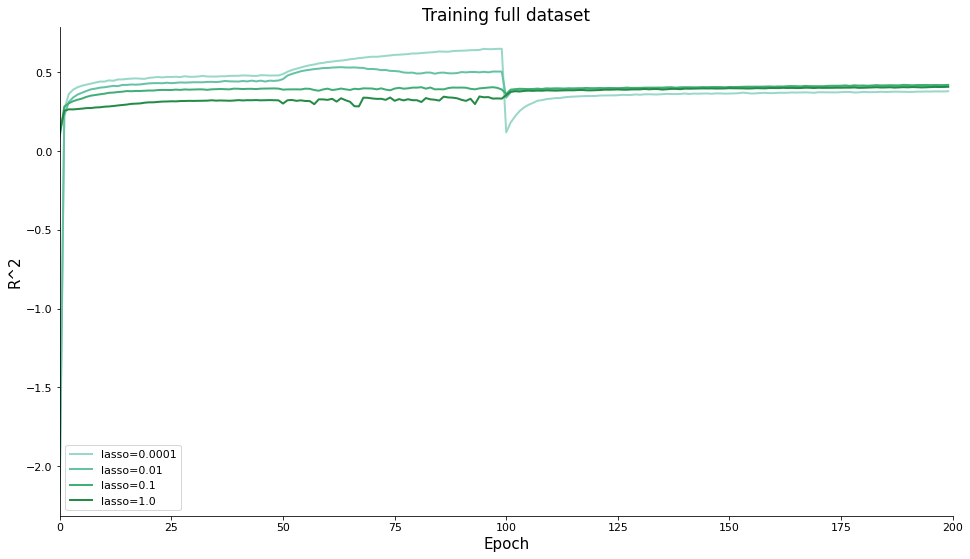

In [17]:
# The learning curves for our favourite model: pre-tr + train last 4 layers only + train all + prune
linewidth = 2

epochs_used = 200
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_Full_Dataset, axis = (1))[j,:], \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
#ax.set_ylim([0, 0.7])
ax.set_xlim([0, 200])
ax.set_title('Training full dataset', fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('R^2', fontsize = 15)
ax.legend(loc='best', fontsize = 11)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
sns.despine()

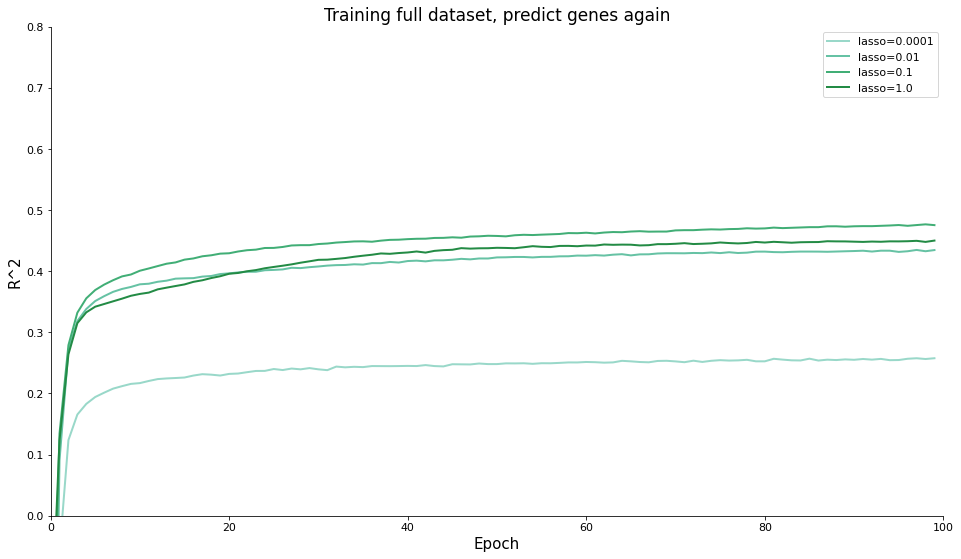

In [18]:
# The learning curves for our favourite model: pre-tr + train last 4 layers only + train all + prune + predict genes again
# i.e. autoencoding decoder
linewidth = 2
epochs_used = 100
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_Full_Dataset_AE, axis = (1))[j,:], \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax.set_ylim([0, 0.8])
ax.set_xlim([0, 100])
ax.set_title('Training full dataset, predict genes again', fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('R^2', fontsize = 15)
ax.legend(loc='best', fontsize = 11)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
sns.despine()

We rerun the same model an additional 9 times to see how many times we select same genes etc.

In [19]:
from bottleneck_networks_tf2 import ClassificationPreTrain

In [20]:
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
nodes_list=[512,128,2,128,512]

t = time.time()
np.random.seed(seed)
n = X.shape[0]
clusters_ = np.copy(clusters)

CE_loss = np.zeros((l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))


pre_train_size = 0.6
train_cnt = round(X.shape[0]*pre_train_size)
x_train_pre_tr_ = X[:train_cnt, :]
x_test_pre_tr_ = X[train_cnt:, :]
clusters_train_pre_tr_ = clusters_[:train_cnt]
clusters_test_pre_tr_ = clusters_[train_cnt:]

for f in range(0,9):
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train_pre_tr_.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr_).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, nodes_list=nodes_list)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold_id+1+f, l1_id=j, l2_id=i, \
                                                                               verbose=0, \
                                                                               output_name='scala_2020_tf2')
            CE_loss[j, i] = CE_test
            CE_loss_tr[j, i] = CE_train
            pre_tr_hist[j, i] = test_hist
            pre_tr_hist_tr[j, i] = train_hist
            #print('Test CE loss (pre-training): ', CE_loss[j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...
Time: 0.0h  1m 40s


In [21]:
from bottleneck_networks_tf2 import FreezeUnfreeze

In [22]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])              # I am only interested in the lasso penalty set to 0.1 here

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True
nodes_list=[512,128,2,128,512]

r2_freeze_unfreeze_hist_tr=np.zeros((l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr_AE=np.zeros((l1_params.shape[0], l2_params.shape[0], 2*epochs)) 

t = time.time()
np.random.seed(seed)
n = X.shape[0]

    
input_dim = X.shape[1]
output_dim = Y.shape[1]

for f in range(9):
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)

            pre_trained_weights_h5 = 'KerasSavedModels/scala_2020_tf2/Classification_last_weights_{}_{}_{}.h5'.\
                                                                                    format(cvfold_id+1+f, j, i)
            input_dim = X.shape[1]
            output_dim = Y.shape[1]
            BN_PreTrFreezeUnfreeze=FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, \
                                                       nodes_list=nodes_list)
            train_hist, AE_hist=BN_PreTrFreezeUnfreeze.train_full_dataset(x_train=X, y_train=Y, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold_id+1+f, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=gene_names, \
                                                                    verbose=0, add_autoencoder=True, \
                                                                    output_name='scala_2020_tf2')
            r2_freeze_unfreeze_hist_tr[j, i]=train_hist
            r2_freeze_unfreeze_hist_tr_AE[j, i]=AE_hist
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Prox1' 'Satb1' 'Tiam2' 'Kcnab3' 'Magel2' 'Mas1' 'Grip1' 'Sparcl1'
 'Fezf2' 'Cplx1' 'Unc13c' 'Dlx6os1' 'Atp1a3' 'Thsd7a' 'Ndst3' 'Htr3a'
 'Synpr' 'Lamp5' 'Tac2' 'Ndn' 'Coro6' 'Gad1' 'Pvalb' 'Vip' 'Sst']
[INFO] training pruning network...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[INFO] training autoencoder network
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Kcnip2' 'Atp1a1' 'Unc13c' 'Lingo2' 'Synpr' 'Galnt14' 'Elfn1' 'Vstm2a'
 'Htr3a' 'Cacna2d3' 'Fxyd6' 'Cbln2' 'Tafa1' 'Npy2r' 'Rab3b' 'Erbb4' 'Reln'
 'Sst' 'Plch2' 'Tac2' 'Lamp5' 'Ndn' 'Pvalb' 'Gad1' 'Vip']
[INFO] training pruning network...
[INFO] training autoencoder network
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Nell2' 'Atp1a3' 'Gm11549' 'Phactr1' 'Kcnc2' 'Dlx6os1' 'Elfn1' 'Gabrd'
 'Galnt14' 'Kcnip2' 'Plch2' 'Enpp2' 'Col24a1' 'Unc13c' 'Ndst3' 'Htr3a'
 'Sparcl1' 'Tac2' 'Gm49948' 'Lamp5' 'Ndn' 'Gad1' 'Pvalb' 'Vip' 'Sst']
[INFO] training pruning network...
[INFO] training autoencoder network
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Elmo1' 'Tac2' 'Cplx1' 'Pcp4l1' 'Unc13c' 'Pcdh7' 'Tiam2' 'Phactr1'
 'Rab3b' 'Grip1' 'Cacna1e' 'Mybpc1' 'Sl

Let us pick our lasso parameter and see the average over cvfolds 25 biggest L2 norms of the first kernel and so on.

In [23]:
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

In [24]:
# !!! Set back to your specified cvfold_id in case you'd like to see the result of your simulations. Here I've used
# the cvfold_id used to reproduce results in the paper.
cvfold_id=1111

In [25]:
weights_before_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_before_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('scala_2020_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_before_unfreezing.append(saved_model.get_weights()[0])
weights_before_unfreezing = np.array(weights_before_unfreezing)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [26]:
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('scala_2020_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
weights_after_unfreezing = np.array(weights_after_unfreezing)

In [27]:
weights_after_unfreezing_ap = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                             format('scala_2020_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing_ap.append(saved_model.get_weights()[0])
weights_after_unfreezing_ap = np.array(weights_after_unfreezing_ap)

In [28]:
weights_after_unfreezing_bootstrapping = []
for f in range(9):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('scala_2020_tf2', cvfold_id+1+f, 0, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing_bootstrapping.append(saved_model.get_weights()[0])
weights_after_unfreezing_bootstrapping.append(weights_after_unfreezing)

And what are the genes selected for sRRR for the different cross validated sets and the lambdau we'd have to pick?

In [29]:
lambdas = np.arange(.1,2,.1)

In [30]:
with open('KerasSavedModels/scala_2020_tf2/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [31]:
with open('KerasSavedModels/scala_2020_tf2/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [32]:
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

seed=42
np.random.seed(seed)
n = X.shape[0]
vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X.astype('float64'), Y.astype('float64'), \
                            lambdau=lambdas[np.isclose(n_rank2, 25, atol=3)][0], alpha=1, rank=2, sparsity='row-wise')
print('For rank 2, ', \
      '\nThese highest genes were selected: ', \
      gene_names[np.sum(vx_rank2, axis = 1)!=0])
vx_rank16, vy_rank16 = sparseRRR.elastic_rrr(X.astype('float64'), Y.astype('float64'), \
                            lambdau=lambdas[np.isclose(n_rank16, 25, atol=3)][0], alpha=1, \
                                             rank=Y.shape[1], sparsity='row-wise')

print('For rank 16, ', \
      '\nThese highest genes were selected: ', \
      gene_names[np.sum(vx_rank16, axis = 1)!=0])

For rank 2,  
These highest genes were selected:  ['Arpp21' 'Bcan' 'Bdnf' 'Cacna1e' 'Cacna2d1' 'Coro6' 'Elfn1' 'Erbb4'
 'Gabrd' 'Gad1' 'Galnt14' 'Htr3a' 'Kcnip2' 'Kcnv1' 'Lamp5' 'Mybpc1'
 'Npas1' 'Nxph1' 'Plch2' 'Ptk2b' 'Pvalb' 'Slc6a1' 'Sst' 'Synpr' 'Tac1']
For rank 16,  
These highest genes were selected:  ['Arpp21' 'Bcan' 'Bdnf' 'Cacna1e' 'Cacna2d1' 'Coro6' 'Elfn1' 'Erbb4'
 'Gabrd' 'Gad1' 'Htr3a' 'Lamp5' 'Mybpc1' 'Nxph1' 'Plch2' 'Ptk2b' 'Pvalb'
 'Slc6a1' 'Sst' 'Synpr' 'Tac1' 'Tafa1' 'Vip']


For the amount of times genes can be selected in 10 different runs (thus ranging from 1 to 10), how many times do they
happen?

In [33]:
import itertools
from collections import Counter

In [34]:
all_genes=[]
all_genes.append(list(gene_names[np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[2, :]
                                 [-25:]]))
for f in range(9):
     all_genes.append(list(gene_names[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[f], \
                                             ord=2, axis=1), axis = 0)][-25:]))
all_genes=np.array(all_genes).reshape(-1)

In [35]:
print('size of the superset of all genes: ', np.unique(all_genes).shape)

size of the superset of all genes:  (70,)


In [36]:
for_hist={}
for i in range(1,11):
    count=0
    for key in Counter(all_genes):
        if Counter(all_genes)[key]==i:
            count+=1
    for_hist.update({i:count})
for_hist

{1: 19, 2: 14, 3: 11, 4: 6, 5: 6, 6: 3, 7: 1, 8: 1, 9: 7, 10: 2}

In [37]:
Counter(all_genes)

Counter({'Rab3b': 3,
         'Elmo1': 2,
         'Col24a1': 4,
         'Mybpc1': 2,
         'Parm1': 2,
         'Cacna1e': 4,
         'Cplx3': 1,
         'Reln': 2,
         'Cbln2': 2,
         'Calb1': 1,
         'Npy1r': 1,
         'Plch2': 9,
         'Fxyd6': 2,
         'Atp1a3': 6,
         'Vip': 8,
         'Gad2': 1,
         'Cplx1': 6,
         'Synpr': 5,
         'Ptk2b': 3,
         'Tafa1': 4,
         'Coro6': 4,
         'Slc6a1': 3,
         'Erbb4': 5,
         'Pvalb': 10,
         'Gad1': 10,
         'Prox1': 1,
         'Satb1': 3,
         'Tiam2': 5,
         'Kcnab3': 2,
         'Magel2': 3,
         'Mas1': 3,
         'Grip1': 2,
         'Sparcl1': 5,
         'Fezf2': 3,
         'Unc13c': 9,
         'Dlx6os1': 6,
         'Thsd7a': 3,
         'Ndst3': 7,
         'Htr3a': 9,
         'Lamp5': 9,
         'Tac2': 9,
         'Ndn': 9,
         'Sst': 9,
         'Kcnip2': 3,
         'Atp1a1': 1,
         'Lingo2': 1,
         'Galnt14': 5,
  

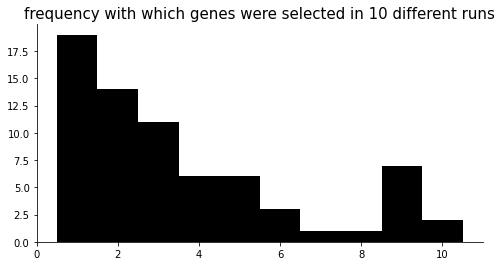

In [38]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.hist(
            x=[key for key in for_hist],
            bins=np.linspace(0.5, 10.5, 11),
            weights=[for_hist[key] for key in for_hist],
            color='k'
        )
ax.set_title('frequency with which genes were selected in 10 different runs', fontsize=15)
sns.despine()
plt.savefig('./figures/preliminary/histogram_genes_for_different_runs.png')

In [68]:
with open('KerasSavedModels/scala_2020_tf2/for_hist.pickle', 'wb') as f:
    pickle.dump(for_hist, f)

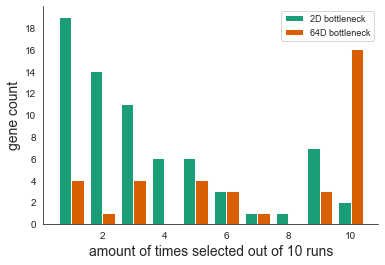

In [105]:
with open('KerasSavedModels/scala_2020_tf2/for_hist.pickle', 'rb') as f:
    for_hist = pickle.load(f)
with open('KerasSavedModels/scala_2020_tf2/for_hist_nb.pickle', 'rb') as f:
    for_hist_nb = pickle.load(f)

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist(
            x=[[key for key in for_hist],
               [key for key in for_hist]],
            bins=np.linspace(0.5, 10.5, 11),
            weights=[[for_hist[key] for key in for_hist],
                     [for_hist_nb[key] for key in for_hist_nb]],
            color=['#1b9e77', '#d95f02'],
            label=['2D bottleneck', '64D bottleneck']
        )
ax.set_ylabel('gene count', fontsize=14)
ax.set_xlabel('amount of times selected out of 10 runs', fontsize=14)
ax.set_yticks(np.linspace(0,18,10))
ax.legend(loc='best', fontsize=9)
sns.despine()
plt.savefig('./figures/preliminary/histogram_genes_for_different_runs.png')
plt.savefig('./figures/preliminary/histogram_genes_for_different_runs.pdf')

In [39]:
print("e.g. {} genes were selected 10 times out of 10".format(for_hist[10]))

e.g. 2 genes were selected 10 times out of 10


In [121]:
print("e.g. {} genes were selected 1 times out of 10".format(for_hist[1]))

e.g. 19 genes were selected 1 times out of 10


How many genes on average are there in common between pairs of runs?

In [40]:
counter_gene_list=[]
gene_list=[]
for pair in itertools.combinations(range(1,10), 2):
    BNN_genes_1=gene_names[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[pair[0]], \
                                             ord=2, axis=1), axis = 0)][-25:]
    if pair[1]==9: # We want 9 to correspond to our cvfold_id=1111 run
        BNN_genes_2=gene_names[np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[2, :][-25:]]
    else:
        BNN_genes_2 = gene_names[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[pair[1]], \
                                             ord=2, axis=1), axis = 0)][-25:]
    counter=0
    for gene in BNN_genes_1:
        if gene in BNN_genes_2:
            counter+=1
            gene_list.append(gene)
    counter_gene_list.append(counter)

In [41]:
counter_gene_list_2=[]
sRRRrank2genes = gene_names[np.sum(vx_rank2, axis = 1)!=0]
for i, weight in enumerate(weights_after_unfreezing_bootstrapping):
    if i==9:
        BNN_genes=gene_names[np.argsort(np.linalg.norm(weight, ord=2, axis=2), axis = 1)[2, :][-25:]]
    else:
        BNN_genes=gene_names[np.argsort(np.linalg.norm(weight, ord=2, axis=1), axis = 0)][-25:]
    counter=0
    for gene in BNN_genes:
        if gene in sRRRrank2genes:
            counter+=1
    counter_gene_list_2.append(counter)

In [42]:
print("On average, {} genes are in common between any pair of runs.".format(np.mean(counter_gene_list)))

On average, 12.722222222222221 genes are in common between any pair of runs.


In [43]:
print("And how many times did every gene get shared between a pair of runs?")
Counter(gene_list)

And how many times did every gene get shared between a pair of runs?


Counter({'Kcnip2': 3,
         'Unc13c': 28,
         'Galnt14': 10,
         'Elfn1': 10,
         'Htr3a': 28,
         'Sst': 28,
         'Plch2': 36,
         'Tac2': 28,
         'Lamp5': 28,
         'Ndn': 28,
         'Pvalb': 36,
         'Gad1': 36,
         'Vip': 21,
         'Tafa1': 6,
         'Rab3b': 3,
         'Erbb4': 10,
         'Vstm2a': 1,
         'Synpr': 6,
         'Fxyd6': 1,
         'Cbln2': 1,
         'Reln': 1,
         'Phactr1': 3,
         'Atp1a3': 10,
         'Dlx6os1': 10,
         'Gabrd': 3,
         'Enpp2': 6,
         'Col24a1': 6,
         'Ndst3': 15,
         'Sparcl1': 6,
         'Gm49948': 6,
         'Gm11549': 1,
         'Kcnc2': 1,
         'Cplx1': 10,
         'Cacna1e': 6,
         'Tiam2': 6,
         'Slc6a1': 3,
         'Satb1': 1,
         'Ptk2b': 3,
         'Adcyap1': 1,
         'Elmo1': 1,
         'Mybpc1': 1,
         'Thsd7a': 1,
         'Kcnab1': 1,
         'Mas1': 1,
         'Fezf2': 1,
         'Coro6': 3,
 

In [44]:
print("On average, {} genes are in common between every run and sRRR rank=2.".format(np.mean(counter_gene_list_2)))

On average, 9.8 genes are in common between every run and sRRR rank=2.


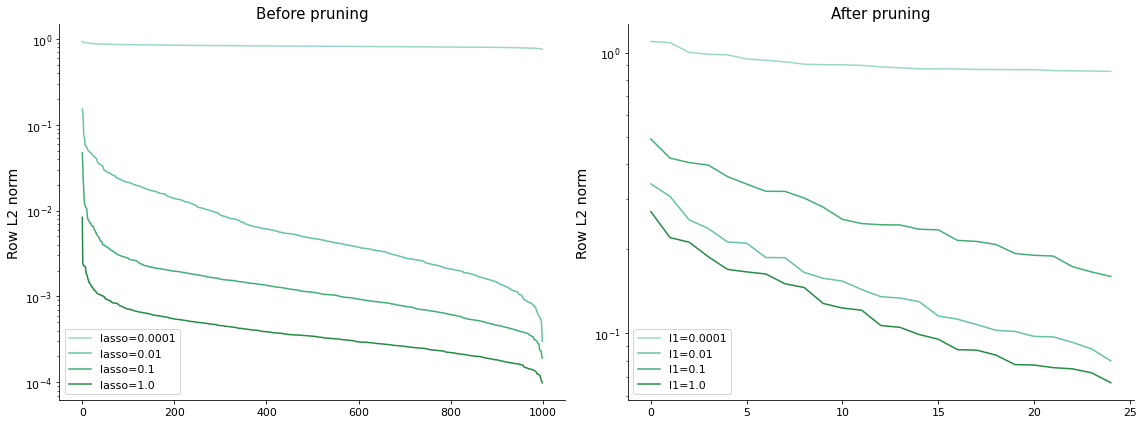

In [45]:
fig = plt.figure(figsize = (16, 6))
ax1 = fig.add_subplot(121)
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax1.plot(range(X.shape[1]), np.sort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'lasso={}'.format(l1))
ax1.set_ylabel('Row L2 norm', fontsize = 14)
ax1.set_title('Before pruning', fontsize = 15)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.tick_params(axis='both', which='minor', labelsize=11)
ax1.set_yscale('log')
ax1.legend(loc='best', fontsize=11)

ax2 = fig.add_subplot(122)
for j, l1 in enumerate(l1_params):
    ax2.plot(range(25), np.sort(np.linalg.norm(weights_after_unfreezing_ap, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'l1={}'.format(l1))
ax2.set_ylabel('Row L2 norm', fontsize = 14)
ax2.set_title('After pruning', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.tick_params(axis='both', which='minor', labelsize=11)
ax2.set_yscale('log')
ax2.legend(loc='best', fontsize=11)
sns.despine()
plt.tight_layout()

In [106]:
# This should be a pickled file created from the other notebook
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
        r2_before_unfreezing, r2_before_unfreezing_tr, \
        r2_after_unfreezing, r2_after_unfreezing_tr, \
        r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
        r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

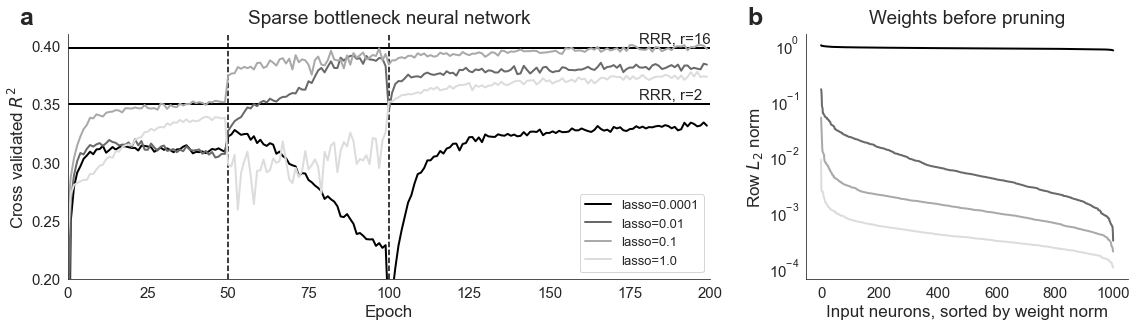

In [122]:
# Everything in one figure for the paper
linewidth = 2
epochs_used = 200
#colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
colours = ['black', 'dimgrey', 'darkgrey', 'gainsboro']
#colours = ['orangered', 'darkgreen', 'turquoise', 'deeppink']
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

fig = plt.figure(figsize=(19, 4.5))
widths = [2, 1]
heights = [1]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])
for j, l1 in enumerate(l1_params):
#     ax1.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis = (0))[j,0,:].T, \
#              '--', c = colours[j], linewidth=linewidth)
    ax1.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis = (0))[j,0,:].T, \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax1.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax1.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax1.annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)][0]+0.004), fontsize=15)
ax1.annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0]+0.004), fontsize=15)
ax1.set_ylim([0.2, 0.41])
ax1.set_xlim([0, epochs_used])
ax1.set_title('Sparse bottleneck neural network', fontsize = 19, y=1.02)
ax1.set_xlabel('Epoch', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.legend(loc='lower right', fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.set_xticks(np.arange(0, 225, 25))
ax1.vlines(x=50, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.vlines(x=100, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')

ax2 = fig.add_subplot(spec[0, 1])
for j, l1 in enumerate(l1_params):
    ax2.plot(range(X.shape[1]), np.sort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'lasso={}'.format(l1), linewidth=linewidth)
ax2.set_ylabel(r'Row $L_2$ norm', fontsize = 17)
ax2.set_xlabel('Input neurons, sorted by weight norm', fontsize = 17)
ax2.set_title('Weights before pruning', fontsize = 19, y=1.02)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_yscale('log')

plt.text(-0.075, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.185, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Lasso_training_curves_freeze_unfreeze_and_weights.png', bbox_inches = 'tight',
   pad_inches = 0.1)
plt.savefig('figures/Lasso_training_curves_freeze_unfreeze_and_weights.pdf', bbox_inches = 'tight',
   pad_inches = 0.1)

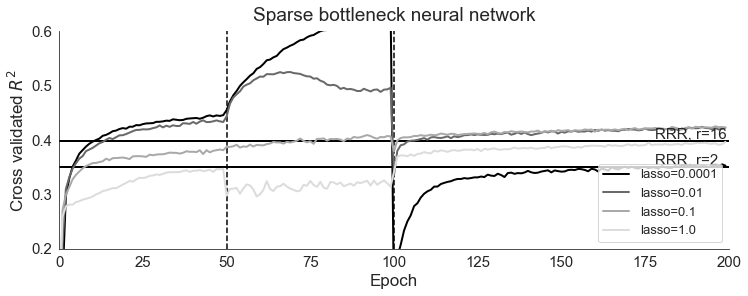

In [118]:
# Everything in one figure for the paper
linewidth = 2
epochs_used = 200
#colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
colours = ['black', 'dimgrey', 'darkgrey', 'gainsboro']
#colours = ['orangered', 'darkgreen', 'turquoise', 'deeppink']
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

fig, ax = plt.subplots(figsize=(12, 4))
for j, l1 in enumerate(l1_params):
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis = (0))[j,0,:].T, \
                 c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)][0]+0.004), fontsize=15)
ax.annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0]+0.004), fontsize=15)
ax.set_ylim([0.2, 0.6])
ax.set_xlim([0, epochs_used])
ax.set_title('Sparse bottleneck neural network', fontsize = 19, y=1.02)
ax.set_xlabel('Epoch', fontsize = 17)
ax.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax.legend(loc='lower right', fontsize = 13)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xticks(np.arange(0, 225, 25))
ax.vlines(x=50, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed')
ax.vlines(x=100, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed')
sns.despine()

plt.savefig('figures/Lasso_training_curves_freeze_unfreeze_and_weights_tr.png', bbox_inches = 'tight',
   pad_inches = 0)
plt.savefig('figures/Lasso_training_curves_freeze_unfreeze_and_weights_tr.pdf', bbox_inches = 'tight',
   pad_inches = 0)

In [48]:
# Print the genes selected for this lasso, our favourite model 
highest_genes = 25
for j, l1 in enumerate(l1_params):
    print('For lasso: {}'.format(l1), \
          '\nThese {} highest genes were selected: '.format(highest_genes), \
         gene_names[np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1][:highest_genes]])

For lasso: 0.0001 
These 25 highest genes were selected:  ['Sash3' 'Cct8' 'Egfr' 'Gpc3' 'Rit2' 'Grip1' 'Ighm' '9530068E07Rik'
 '5330413P13Rik' 'Zfp719' 'Pvalb' 'Mdh1' 'Vip' 'Sema5a' 'Prox1' 'Idh3b'
 'Lcp1' 'Zfp551' 'Tiam2' 'Prkacb' 'AW551984' 'Grm1' 'Ptk2b' 'Thoc1' 'Ccl9']
For lasso: 0.01 
These 25 highest genes were selected:  ['Pvalb' 'Vip' 'Gad1' 'Egfr' 'Prox1' 'Cplx3' 'Tnnt1' 'Gm49948' 'Arpp19'
 'Dlx6os1' 'Atp1a3' 'Elmo1' 'Eef1a1' 'Thsd7a' 'Rasgrp1' 'Rph3a' 'Sparcl1'
 'Hpse' 'Tiam2' 'Nrp1' 'Pamr1' 'Ptgs2' 'Grik1' 'Slc6a1' 'Bcl2l11']
For lasso: 0.1 
These 25 highest genes were selected:  ['Gad1' 'Pvalb' 'Erbb4' 'Slc6a1' 'Coro6' 'Tafa1' 'Ptk2b' 'Synpr' 'Cplx1'
 'Gad2' 'Vip' 'Atp1a3' 'Fxyd6' 'Plch2' 'Npy1r' 'Calb1' 'Cbln2' 'Reln'
 'Cplx3' 'Cacna1e' 'Parm1' 'Mybpc1' 'Col24a1' 'Elmo1' 'Rab3b']
For lasso: 1.0 
These 25 highest genes were selected:  ['Pvalb' 'Sst' 'Vip' 'Htr3a' 'Tac2' 'Gabrd' 'Gm49948' 'Gad1' 'Synpr'
 'Cplx1' 'Lamp5' 'Tac1' 'Parm1' 'Gng4' 'Pcp4l1' 'Cck' '6330403K07Rik'
 '

In [49]:
np.round(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2)\
    [2,np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[2, ::-1]][:highest_genes],3)

array([0.047, 0.034, 0.022, 0.019, 0.014, 0.012, 0.011, 0.011, 0.011,
       0.011, 0.01 , 0.009, 0.008, 0.008, 0.008, 0.008, 0.007, 0.007,
       0.007, 0.007, 0.007, 0.007, 0.007, 0.007, 0.007], dtype=float32)

In [50]:
np.round(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2)\
    [2,np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[2, ::-1]][:highest_genes],3).shape

(25,)

# Visualization latent spaces

In [51]:
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Text(0.5, 1.0, 'Latent space')

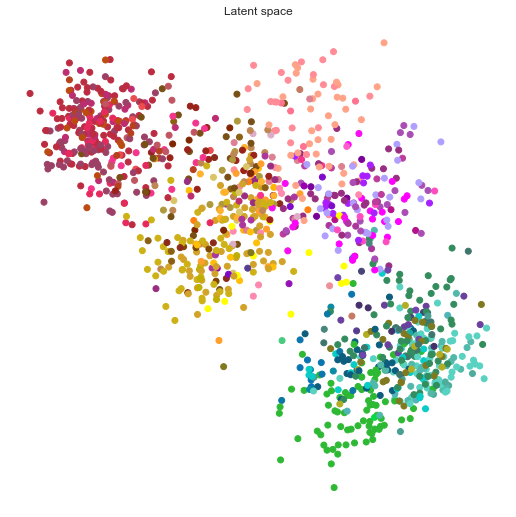

In [52]:
# Before unfreezing
cvfold_id=1111
lasso_id=2 # a number from 0 to 3 (corresponding to 1e-4, 1e-2, 1e-1, 1 lasso penalty respectively)
saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_before_unfreezing_full_dataset_{}_{}_{}.h5'.\
                        format('scala_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
#ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
#                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
latent = encoder.predict(X)                 # bottleneck representation

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [colors[ctype] for ctype in cell_id_to_cell_type]) #TODO adapt wisely here (so that it works for Scala too)
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space')

R^2 score on all:  0.42766422033309937


Text(0.5, 1.0, 'Latent space')

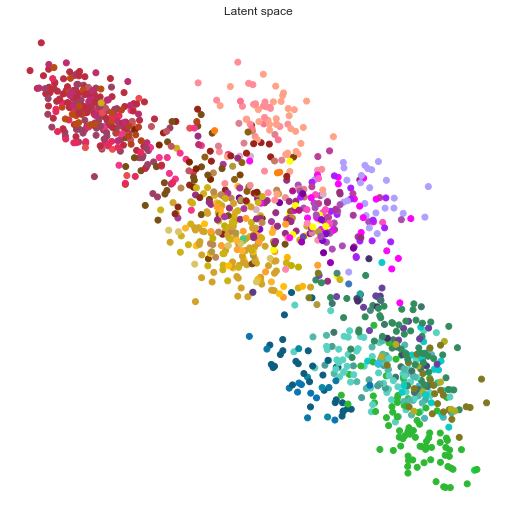

In [53]:
# After unfreezing
lasso_id=2
cvfold_id=1111
saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                        format('scala_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
#ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
#                                  [saved_model.output])

#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
latent = encoder.predict(X)                 # bottleneck representation
ephys_prediction = saved_model.predict(X)   # class prediction
print('R^2 score on all: ', 1-np.sum((Y - saved_model.predict(x=X))**2) / np.sum(Y**2))

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [colors[ctype] for ctype in cell_id_to_cell_type])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space')

R^2 score on all:  0.42584145069122314


Text(0.5, 1.0, 'Latent space')

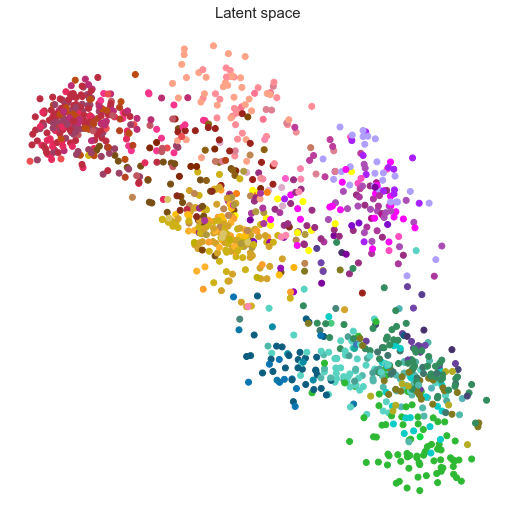

In [54]:
# After pruning
lasso_id=2
cvfold_id=1111
saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('scala_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X[:, ind_genes])                 # bottleneck representation
ephys_prediction = saved_model.predict(X[:, ind_genes])             # class prediction
print('R^2 score on all: ', 1-np.sum((Y - \
                                      saved_model.predict(x=X[:, ind_genes]))**2) / np.sum(Y**2))

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [colors[ctype] for ctype in cell_id_to_cell_type])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space', fontsize=15)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


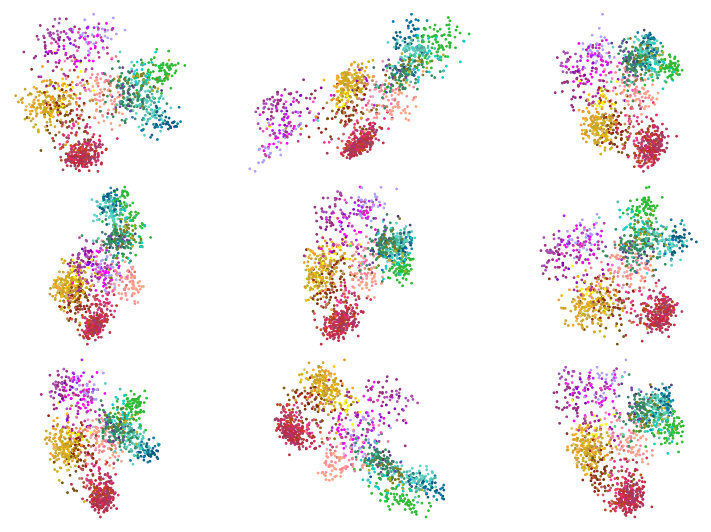

In [119]:
# suppl information, together
fig = plt.figure(figsize=(12, 8))
width=0.3
height=0.3
ax_latents=[plt.axes([0,0.6,width,height]),plt.axes([0.3,0.6,width,height]),plt.axes([0.6,0.6,width,height]),
            plt.axes([0,0.3,width,height]),plt.axes([0.3,0.3,width,height]),
            plt.axes([0.6,0.3,width,height]),plt.axes([0,0,width,height]),
            plt.axes([0.3,0,width,height]),plt.axes([0.6,0,width,height])]

for i, ax in enumerate(ax_latents):
    cvfold_id=1111+1+i
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                    format('scala_2020_tf2', cvfold_id, 0, 0), \
                    custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})
    ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[i], \
                                         ord=2, axis=1), axis = 0)[-25:]
    
    encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
    latent = encoder.predict(X[:, ind_genes])
    if (i==1)|(i==7):
        ax.scatter(-latent[:, 0], latent[:, 1],
                c = [colors[ctype] for ctype in cell_id_to_cell_type], s=3)
    elif (i==2):
        ax.scatter(-latent[:, 0], -latent[:, 1],
                c = [colors[ctype] for ctype in cell_id_to_cell_type], s=3)       
    elif (i==4)|(i==8):
        ax.scatter(latent[:, 0], -latent[:, 1],
                c = [colors[ctype] for ctype in cell_id_to_cell_type], s=3)  
    else:    
        ax.scatter(latent[:, 0], latent[:, 1],
                c = [colors[ctype] for ctype in cell_id_to_cell_type], s=3)
    ax.set_aspect('equal', adjustable='box')
for ax in ax_latents:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom = True, left = True)
plt.savefig('./figures/preliminary/different_runs_gene_histogram.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('./figures/preliminary/different_runs_gene_histogram.pdf', bbox_inches = 'tight',
     pad_inches = 0)

In [56]:
import matplotlib.tri as tri

In [57]:
def latent_space_ephys(model, X, Y, Y_column_index, features, alpha = 1, axis = None):
    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    Y: 2D numpy array, normalized ephys data
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    # Create mappings from the model to get latent activations from genes and ephys predictions from genes and
    # latent activations
    encoder = Model(model.input, model.get_layer('bottleneck').output)
    latent = encoder.predict(X)
    ephys_prediction = model.predict(X)

    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
        
    # produces triangles from latent coordinates
    triang = tri.Triangulation(latent[:,0], latent[:,1])
    
    # extract coordinates of eacht triangle
    x1=latent[:,0][triang.triangles][:,0]
    x2=latent[:,0][triang.triangles][:,1]
    x3=latent[:,0][triang.triangles][:,2]
    y1=latent[:,1][triang.triangles][:,0]
    y2=latent[:,1][triang.triangles][:,1]
    y3=latent[:,1][triang.triangles][:,2]
    
    # calculate the area of each triangle
    #A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 50th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-25])
    
    ax.tricontourf(triang, ephys_prediction[:, Y_column_index], cmap='inferno',
                   levels=np.linspace(-2,2,40), extend='both')
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [58]:
def latent_space_genes(model, latent, X, X_column_index, geneNames, alpha = 1, axis = None):
    '''
    Parameters
    ----------
    model: keras decoder network (from latent space to selected genes)
    latent: bottleneck activations
    X: 2D numpy array, normalized transcriptomic data (should be a selected genes i.e. reduced size matrix)
    X_column_index: column index in X, correspoding to certain gene
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    gene_prediction=model.predict(latent)
    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation(latent[:,0], latent[:,1])
    
    # extract coordinates of eacht triangle
    x1=latent[:,0][triang.triangles][:,0]
    x2=latent[:,0][triang.triangles][:,1]
    x3=latent[:,0][triang.triangles][:,2]
    y1=latent[:,1][triang.triangles][:,0]
    y2=latent[:,1][triang.triangles][:,1]
    y3=latent[:,1][triang.triangles][:,2]
    
    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 50th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-25])
    ax.tricontourf(triang, gene_prediction[:, X_column_index], cmap='inferno',
                   levels=np.linspace(-2,2,40), extend='both')
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[X_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [59]:
def create_axes(fig):
    # return axes to construct figure
    
    if fig is None:
        fig = plt.figure(figsize=(16, 16/3)) # width/height ratio of 3
    else: fig = fig
    
    ax_latent=plt.axes([.33,0,0.33,0.99])
    ax_genes_1=plt.axes([0,0.66,0.11,0.3])
    ax_genes_2=plt.axes([0.11,0.66,0.11,0.3])
    ax_genes_3=plt.axes([0.22,0.66,0.11,0.3])
    ax_genes_4=plt.axes([0,0.33,0.11,0.3])
    ax_genes_5=plt.axes([0.11,0.33,0.11,0.3])
    ax_genes_6=plt.axes([0.22,0.33,0.11,0.3])
    ax_genes_7=plt.axes([0,0,0.11,0.3])
    ax_genes_8=plt.axes([0.11,0,0.11,0.3])
    ax_genes_9=plt.axes([0.22,0,0.11,0.3])
    ax_ephys_1=plt.axes([0.66,0.66, 0.11, 0.3])
    ax_ephys_2=plt.axes([0.77,0.66, 0.11, 0.3])
    ax_ephys_3=plt.axes([0.88,0.66, 0.11, 0.3])
    ax_ephys_4=plt.axes([0.66,0.33, 0.11, 0.3])
    ax_ephys_5=plt.axes([0.77,0.33, 0.11, 0.3])
    ax_ephys_6=plt.axes([0.88,0.33, 0.11, 0.3])
    ax_ephys_7=plt.axes([0.66,0, 0.11, 0.3])
    ax_ephys_8=plt.axes([0.77,0, 0.11, 0.3])
    ax_ephys_9=plt.axes([0.88,0, 0.11, 0.3])
    
    return [ax_latent, ax_genes_1, ax_genes_2, ax_genes_3, ax_genes_4, ax_genes_5, ax_genes_6, ax_genes_7, ax_genes_8, \
           ax_genes_9, ax_ephys_1, ax_ephys_2, ax_ephys_3, ax_ephys_4, ax_ephys_5, ax_ephys_6, ax_ephys_7, ax_ephys_8, \
           ax_ephys_9]

In [60]:
lasso_id=2
cvfold_id=1111
saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('scala_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X[:, ind_genes])                 # bottleneck representation

saved_model_AE = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('scala_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


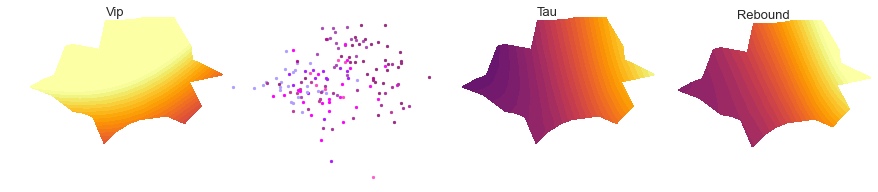

In [121]:
# first zoomed in for Vip for the revision

# Select Vip neurons
Vip_list=['Vip Sncg', 'Vip Serpinf1_1', 'Vip Serpinf1_2', 'Vip Serpinf1_3', 'Vip Htr1f',
 'Vip Gpc3', 'Vip C1ql1', 'Vip Mybpc1_1', 'Vip Mybpc1_2', 'Vip Mybpc1_3', 'Vip Chat_1',
 'Vip Chat_2', 'Vip Igfbp6_1', 'Vip Igfbp6_2']

Vip_cells=cell_id_to_cell_type==Vip_list[0]
for ctype in Vip_list[1:]:
    Vip_cells|=cell_id_to_cell_type==ctype
Vip_cells=np.where(Vip_cells==True)[0]

# visualize
fig = plt.figure(figsize=(12, 3))
ax_genes_1=plt.axes([0,0,.25,1])
ax_latent=plt.axes([.25,0,.25,1])
ax_ephys_1=plt.axes([.5,0,.25, 1])
ax_ephys_2=plt.axes([.75,.075,.25, 1])
for ctype in Vip_list:
    ax_latent.scatter(latent[np.array(cell_id_to_cell_type)==ctype, 0],
                      latent[np.array(cell_id_to_cell_type)==ctype, 1], c = colors[ctype], s=5)
#ax_latent.set_ylim(1, ax_latent.get_ylim()[1])
ax_latent.set_xticks([])
ax_latent.set_yticks([])
latent_space_genes(saved_model_AE, latent[Vip_cells,:],
                   X[Vip_cells,:][:,ind_genes], 
        np.where(gene_names[ind_genes]=='Vip')[0][0], gene_names[ind_genes], axis=ax_genes_1)
latent_space_ephys(saved_model, X[Vip_cells,:][:,ind_genes], Y[Vip_cells,:], \
        np.where(ephys_names=='Tau')[0][0], ephys_names, axis=ax_ephys_1)
latent_space_ephys(saved_model, X[Vip_cells,:][:,ind_genes], Y[Vip_cells,:], \
        np.where(ephys_names=='Rebound')[0][0], ephys_names, axis=ax_ephys_2)
ax_ephys_2.set_ylim(1, ax_latent.get_ylim()[1])
ax_ephys_2.set_title('Rebound', fontsize=13, y=0.91)
sns.despine(left=True, bottom=True)
for ax in [ax_genes_1, ax_latent, ax_ephys_1, ax_ephys_2]:
    ax.set_aspect(aspect='equal')
plt.savefig('figures/preliminary/Vip_zoomed_in.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/preliminary/Vip_zoomed_in.pdf', bbox_inches = 'tight',
    pad_inches = 0)

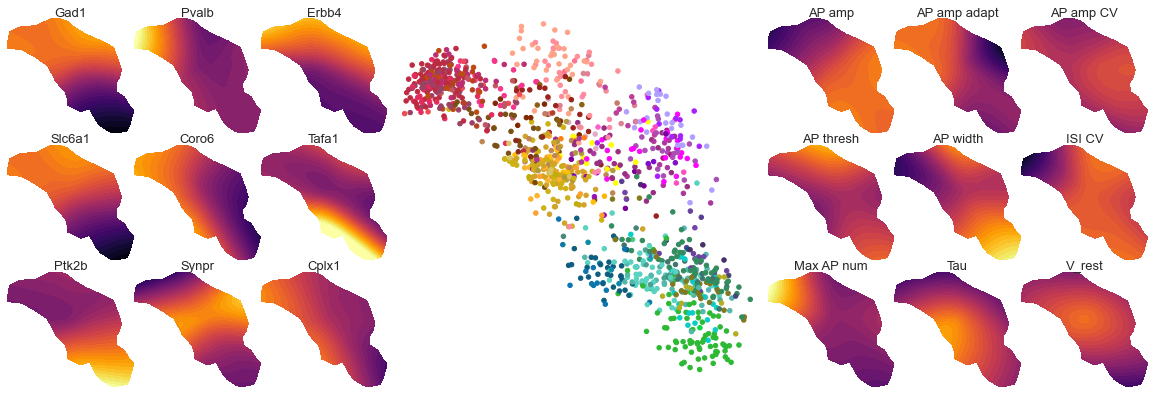

In [61]:
fig = plt.figure(figsize=(16, 16/3)) # width/height ratio of 3

ax_list = create_axes(fig)

ax_list[0].scatter(latent[:, 0], latent[:, 1],
            c = [colors[ctype] for ctype in cell_id_to_cell_type], s=20)
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
#e = Ellipse((-.3, 0.3), 9, 9, edgecolor='k', facecolor='white', angle=0, zorder=-1)
#ax_list[0].add_artist(e)
for i, ax in enumerate(ax_list[1:10]):
    latent_space_genes(saved_model_AE, latent, X[:, ind_genes], 
        -(i+1), gene_names[ind_genes], axis=ax)
ephys_feature_indices_for_visualization=[0,1,2,3,4,7,9,10,12]
for i, ax in enumerate(ax_list[10:]):
    latent_space_ephys(saved_model, X[:, ind_genes], Y, \
        ephys_feature_indices_for_visualization[i], ephys_names, axis=ax)
sns.despine(left=True, bottom=True)

plt.savefig('figures/Bottleneck_latent_space_all_together.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/Bottleneck_latent_space_all_together.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [62]:
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

seed=42
np.random.seed(seed)
n = X.shape[0]

vx_rank2, vy_rank2 = sparseRRR.relaxed_elastic_rrr(X.astype('float64'), Y.astype('float64'), \
                            lambdau=lambdas[np.isclose(n_rank2, 25, atol=3)][0], alpha=1, rank=2, sparsity='row-wise')
print('For rank 2, ', \
      '\nThese highest genes were selected: ', \
      gene_names[np.sum(vx_rank2, axis = 1)!=0])
vx_rank16, vy_rank16 = sparseRRR.relaxed_elastic_rrr(X.astype('float64'), Y.astype('float64'), \
                            lambdau=lambdas[np.isclose(n_rank16, 25, atol=3)][0], alpha=1, \
                                             rank=16, sparsity='row-wise')

print('For rank 16, ', \
      '\nThese highest genes were selected: ', \
      gene_names[np.sum(vx_rank16, axis = 1)!=0])

For rank 2,  
These highest genes were selected:  ['Arpp21' 'Bcan' 'Bdnf' 'Cacna1e' 'Cacna2d1' 'Coro6' 'Elfn1' 'Erbb4'
 'Gabrd' 'Gad1' 'Galnt14' 'Htr3a' 'Kcnip2' 'Kcnv1' 'Lamp5' 'Mybpc1'
 'Npas1' 'Nxph1' 'Plch2' 'Ptk2b' 'Pvalb' 'Slc6a1' 'Sst' 'Synpr' 'Tac1']
For rank 16,  
These highest genes were selected:  ['Arpp21' 'Bcan' 'Bdnf' 'Cacna1e' 'Cacna2d1' 'Coro6' 'Elfn1' 'Erbb4'
 'Gabrd' 'Gad1' 'Htr3a' 'Lamp5' 'Mybpc1' 'Nxph1' 'Plch2' 'Ptk2b' 'Pvalb'
 'Slc6a1' 'Sst' 'Synpr' 'Tac1' 'Tafa1' 'Vip']


In [63]:
def latent_space_ephys_sRRR(X, vx, vy, Y_column_index, features, alpha = 1, axis = None):

    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure object, latent space with ephys activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation((X@vx)[:,1], (X@vx)[:,0])
    
    # extract coordinates of eacht triangle
    x1=(X@vx)[:,1][triang.triangles][:,0]
    x2=(X@vx)[:,1][triang.triangles][:,1]
    x3=(X@vx)[:,1][triang.triangles][:,2]
    y1=(X@vx)[:,0][triang.triangles][:,0]
    y2=(X@vx)[:,0][triang.triangles][:,1]
    y3=(X@vx)[:,0][triang.triangles][:,2]
    
    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-20])
    ax.tricontourf(triang, (X@vx@vy.T)[:, Y_column_index], cmap='inferno',
                   levels=np.linspace(-1,1,40), extend='both')
    
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [64]:
def latent_space_genes_sRRR(X, vx, index, geneNames, alpha = 0.5, axis = None):
    ''' 
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    index: index in the 25 genes selected for the gene that you'd like to show
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)
    
    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation((X@vx)[:,1], (X@vx)[:,0])
    
    # extract coordinates of eacht triangle
    x1=(X@vx)[:,1][triang.triangles][:,0]
    x2=(X@vx)[:,1][triang.triangles][:,1]
    x3=(X@vx)[:,1][triang.triangles][:,2]
    y1=(X@vx)[:,0][triang.triangles][:,0]
    y2=(X@vx)[:,0][triang.triangles][:,1]
    y3=(X@vx)[:,0][triang.triangles][:,2]
    
    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-20])
    ax.tricontourf(triang, X@vx@np.linalg.pinv(vx)[:, np.sum(vx, axis = 1)!=0][:, index], cmap='inferno',
                   levels=np.linspace(-1,1,40), extend='both')
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[np.sum(vx, axis = 1)!=0][index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

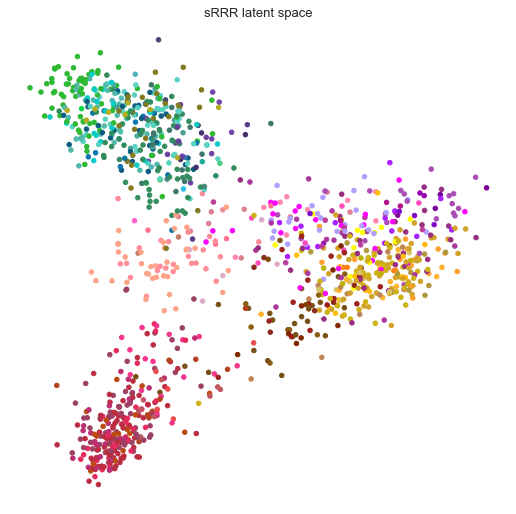

In [65]:
vx_rank2, vy_rank2 = sparseRRR.relaxed_elastic_rrr(X.astype('float64'), Y.astype('float64'), \
                                           lambdau=lambdas[np.isclose(n_rank2, 25, atol=3)][0],\
                                           alpha=1, rank=2, sparsity='row-wise')    
fig, ax = plt.subplots(1,1, figsize=(9,9))

ax.scatter((X@vx_rank2)[:, 1], (X@vx_rank2)[:, 0],
            c = [colors[ctype] for ctype in cell_id_to_cell_type], s=20)
ax.set_title('sRRR latent space', fontsize=13, y=0.99)
ax.set_xticks([])
ax.set_yticks([])
sns.despine(ax=ax, left=True, bottom=True)

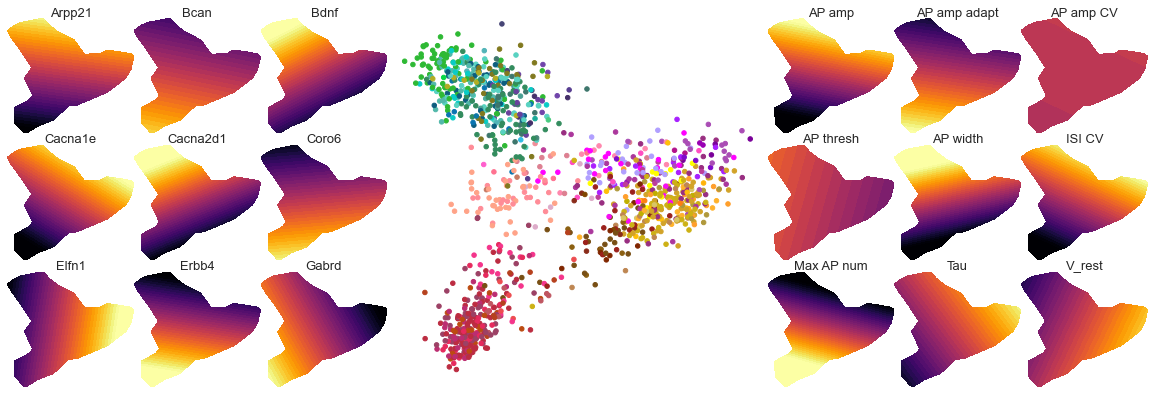

In [66]:
fig = plt.figure(figsize=(16, 16/3)) # width/height ratio of 3

ax_list = create_axes(fig)
vx_rank2, vy_rank2 = sparseRRR.relaxed_elastic_rrr(X.astype('float64'), Y.astype('float64'), \
                                           lambdau=lambdas[np.isclose(n_rank2, 25, atol=3)][0],\
                                           alpha=1, rank=2, sparsity='row-wise')    
ax_list[0].scatter((X@vx_rank2)[:, 1], (X@vx_rank2)[:, 0],
            c = [colors[ctype] for ctype in cell_id_to_cell_type], s=20)
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
#e = Ellipse((-1, 1), 4, 4, edgecolor='k', facecolor='white', zorder=-1)
#ax_list[0].add_artist(e)
for i, ax in enumerate(ax_list[1:10]):
    latent_space_genes_sRRR(X, vx_rank2, 
        i, gene_names, axis=ax)
ephys_feature_indices_for_visualization=[0,1,2,3,4,7,9,10,12]
for i, ax in enumerate(ax_list[10:]):
    latent_space_ephys_sRRR(X, vx_rank2, vy_rank2, \
        ephys_feature_indices_for_visualization[i], ephys_names, axis=ax)
sns.despine(left=True, bottom=True)

plt.savefig('figures/Bottleneck_latent_space_all_together_sRRR.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/Bottleneck_latent_space_all_together_sRRR.pdf', bbox_inches = 'tight',
    pad_inches = 0)